In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('./Python_Functions')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [2]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets data location
experiment = 'E338'
runname = '12691'

### Load dataset

In [3]:
# Loads dataset
dataloc = 'data/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = [1]

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = xrange


# gaussian filter parameter
hotPixThreshold = 1e3
sigma = 5
threshold = 5

In [4]:
# Extract current profiles and 2D LPS images 
xtcavImages_list = []
horz_proj_list = []

for a in range(len(stepsAll)):
    if len(stepsAll) == 1:
        raw_path = data_struct.images.DTOTR2.loc
    else: 
        raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = 'data/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        img_filtered = median_filter(image_cropped, size=3)
        hotPixels = img_filtered > hotPixThreshold
        img_filtered = np.ma.masked_array(img_filtered, hotPixels)
        processed_image = gaussian_filter(img_filtered, sigma=sigma, radius = 6*sigma + 1)
        processed_image[processed_image < threshold] = 0.0
        Nrows = np.array(image_cropped).shape[0]
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_cropped, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)

# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_28819/2308053898.py:39: RuntimeWarning: invalid value encountered in divide
  centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)


In [5]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

In [170]:
matstruct_to_dict(data_struct)['scalars']['nonBSA_List_LINAC_KLYS'].keys()

dict_keys(['LI11_KLYS_11_PDES', 'LI11_KLYS_21_PDES', 'LI11_KLYS_31_PDES', 'LI11_KLYS_41_PDES', 'LI11_KLYS_51_PDES', 'LI11_KLYS_61_PDES', 'LI11_KLYS_71_PDES', 'LI11_KLYS_81_PDES', 'LI11_KLYS_11_PHAS', 'LI11_KLYS_21_PHAS', 'LI11_KLYS_31_PHAS', 'LI11_KLYS_41_PHAS', 'LI11_KLYS_51_PHAS', 'LI11_KLYS_61_PHAS', 'LI11_KLYS_71_PHAS', 'LI11_KLYS_81_PHAS', 'LI11_KLYS_11_ADES', 'LI11_KLYS_21_ADES', 'LI11_KLYS_31_ADES', 'LI11_KLYS_41_ADES', 'LI11_KLYS_51_ADES', 'LI11_KLYS_61_ADES', 'LI11_KLYS_71_ADES', 'LI11_KLYS_81_ADES', 'LI11_KLYS_11_AMPL', 'LI11_KLYS_21_AMPL', 'LI11_KLYS_31_AMPL', 'LI11_KLYS_41_AMPL', 'LI11_KLYS_51_AMPL', 'LI11_KLYS_61_AMPL', 'LI11_KLYS_71_AMPL', 'LI11_KLYS_81_AMPL', 'KLYS_LI11_11_SSSB_PDES', 'KLYS_LI11_21_SSSB_PDES', 'LI12_KLYS_11_PDES', 'LI12_KLYS_21_PDES', 'LI12_KLYS_31_PDES', 'LI12_KLYS_41_PDES', 'LI12_KLYS_51_PDES', 'LI12_KLYS_61_PDES', 'LI12_KLYS_71_PDES', 'LI12_KLYS_81_PDES', 'LI12_KLYS_11_PHAS', 'LI12_KLYS_21_PHAS', 'LI12_KLYS_31_PHAS', 'LI12_KLYS_41_PHAS', 'LI12_KLYS_51

In [152]:
xtcavPhase = matstruct_to_dict(data_struct)['scalars']['nonBSA_List_LINAC_KLYS']['TCAV_LI20_2400_S_PV'][DTOTR2commonind]

### Calculate the current profile normalizing the integral to the charge

In [7]:
def plot_xtcav_image(idx):
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3))
    idx = goodShots[idx]
    ax1.imshow(xtcavImages[:,:,all_idx][:,:,idx], cmap = "jet",aspect='auto')
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(xlim = (0,200))
    ax1.set(ylim= (0,200))

    ax2.plot(currentProfile_all[idx,:])
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "Current [kA]")
    plt.tight_layout()
    fig.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=len(goodShots)-1, step=1, value=0))

NameError: name 'interact' is not defined

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_28819/731207200.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


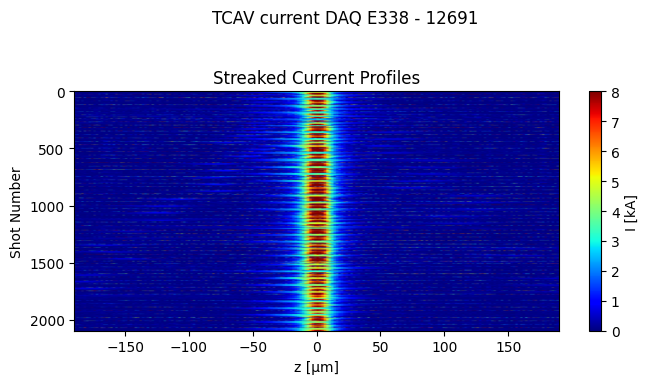

In [6]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

# minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
# plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]
# all_idx = np.append(minus_90_idx,plus_90_idx)
all_idx = np.arange(xtcavImages.shape[2])
currentProfile_all = [] 

# Process all degree shots
for ij in range(len(all_idx)):
    idx = all_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)
    
currentProfile_all = np.array(currentProfile_all)


# Plot
plt.figure(figsize=(7, 4))

# # Subplot for -90°
# plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_all, aspect='auto', cmap='jet', vmin=0, vmax=8, extent=[extent_x[0], extent_x[-1], all_idx[-1], all_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title('Streaked Current Profiles')
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

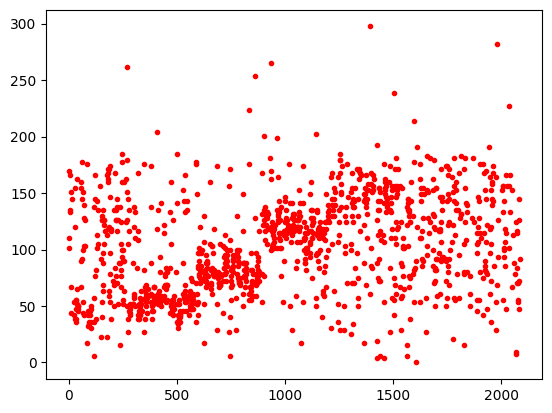

In [187]:
from scipy.signal import find_peaks, peak_prominences

bunchSeparation_all = []
currentRatio_all = []

separationCutoff = 0.05

for ij in range(len(all_idx)):
    profile = currentProfile_all[ij, :] 
    peaks, _ = find_peaks(profile)
    prominences = peak_prominences(profile, peaks)[0]
    if len(prominences) < 2:
        bunchSeparation_all.append(0)
        continue
    
    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[1]]) * separationCutoff > abs(prominences[top2_indices[0]]):
        peak_separation = 0

    bunchSeparation_all.append(peak_separation * xtcalibrationfactor)
    currentRatio_all.append(profile[pos[1]] / profile[pos[0]])

bunch_sep_um = np.array(bunchSeparation_all) * 3e8 * 1e6
currentRatio_all = np.array(currentRatio_all)

goodShots = np.where(currentRatio_all < 16)[0]

plt.plot(all_idx[goodShots], bunch_sep_um[goodShots], 'r.')

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_28819/636992216.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


Fit failed at index 56
Fit failed at index 59
Fit failed at index 351
Fit failed at index 1001
Fit failed at index 1093
Fit failed at index 1094
Fit failed at index 1100
Fit failed at index 1121
Fit failed at index 1342
Fit failed at index 1343
Fit failed at index 1348
Fit failed at index 1349
Fit failed at index 1398
Fit failed at index 1402
Fit failed at index 1409
Fit failed at index 1461
Fit failed at index 1463


/Users/siddhant/Library/Python/3.12/lib/python/site-packages/scipy/optimize/_minpack_py.py:497: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


Fit failed at index 1599
Fit failed at index 1601
Fit failed at index 1602
Fit failed at index 1605
Fit failed at index 1606
Fit failed at index 1608
Fit failed at index 1609
Fit failed at index 1610
Fit failed at index 1659
Fit failed at index 1662
Fit failed at index 1668
Fit failed at index 1671
Fit failed at index 1672
Fit failed at index 1717
Fit failed at index 1718
Fit failed at index 1719
Fit failed at index 1720
Fit failed at index 1721
Fit failed at index 1725
Fit failed at index 1726
Fit failed at index 1727
Fit failed at index 1729
Fit failed at index 1731
Fit failed at index 1732
Fit failed at index 1774
Fit failed at index 1777
Fit failed at index 1779
Fit failed at index 1780
Fit failed at index 1784
Fit failed at index 1790
Fit failed at index 1792
Fit failed at index 1921


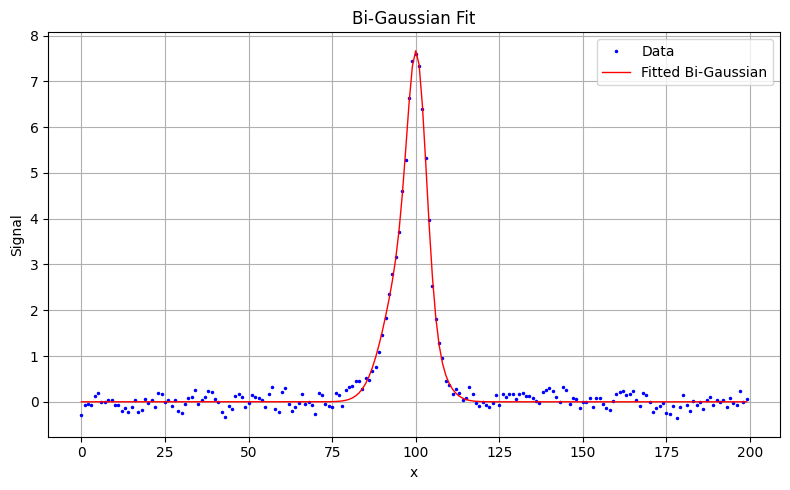

In [7]:
# fit bi-Gaussian to -90 deg 

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
amp1 = []
amp2 = []
sigma1 = []
sigma2 = []
R_squared = []

params = []

for ij in range(len(all_idx)):
    y = currentProfile_all[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    if xtcavPhase[all_idx][ij] < 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60 + ij*0.15, 4]
    elif xtcavPhase[all_idx][ij] > 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60, 4]
    
    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        amp1.append(np.nan)
        amp2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        params.append([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    amp1.append(A1)
    amp2.append(A2)
    sigma1.append(sig1)
    sigma2.append(sig2)
    params.append(popt)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp1 = np.array(amp1)
amp2 = np.array(amp2)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

goodShots = np.where((R_squared > 0.97) & (amp1 < 50))[0]
params = np.array(params)
# Plot the sigma of the drive and witness
# Plot the data and the fit

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [164]:
bigaussian_profiles = []
x = np.arange(0,200,1)
for i in goodShots:
    A1, mu1, s1, A2, mu2, s2 = params[i,:]
    bigaussian_profiles.append([bi_gaussian(x, A1,mu1, s1, A2, mu2, s2)])
    # bigaussian_profiles.append([params[i,:]])
bigaussian_profiles = np.concatenate(bigaussian_profiles, axis = 0)


In [156]:
def plot_profile(idx):
    i = goodShots[idx]
    x = np.arange(0,200,1)
    A1 = amp1[i]
    A2 = amp2[i]
    mu1 = mean1[i]
    mu2 = mean2[i]
    s1 = sigma1[i]
    s2 = sigma2[i]
    plt.plot(x, bi_gaussian(x, A1,mu1, s1, A2, mu2, s2))
    plt.plot(currentProfile_all[i,:], label = 'true')
    plt.xlabel("x")
    plt.ylabel("I [kA]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create slider
interact(plot_profile, idx=IntSlider(min=0, max=goodShots.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=512), Output()), _dom_classes=('widget-interac…

<function __main__.plot_profile(idx)>

In [203]:
# 20-best parameter fit (bsaScalar PVs + step number)
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,goodShots], steps[goodShots])).T
Iz = currentProfile_all[goodShots,:]

nsims=predictor.shape[0]
X = predictor

# 80/20 train-test split
ntrain = int(np.round(nsims*0.8))
ntest = int(np.round(nsims*0.2))

idx = np.random.permutation(nsims)
idxtrain = idx[0:ntrain]
idxtest = idx[ntrain:ntrain+ntest]

# Iz_scaled = Iz# /np.max(Iz)
# Iz_train_scaled = Iz_scaled[idxtrain]
# Iz_test_scaled = Iz_scaled[idxtest] 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(predictor)
x_train_scaled = x_scaled[idxtrain]
x_test_scaled = x_scaled[idxtest]

Iz_scaled = scaler.fit_transform(Iz)
Iz_train_scaled = Iz_scaled[idxtrain,:]
Iz_test_scaled = Iz_scaled[idxtest,:]

Train R^2: 90.009  %
Test R^2: 91.754  %


Text(0.5, 0, 'Epoch')

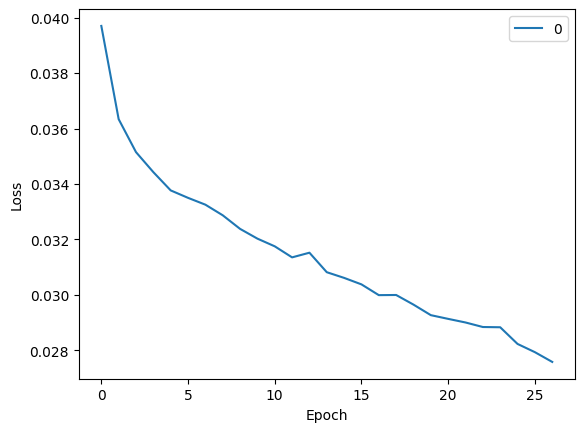

In [45]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

# compress pixels 
pca = PCA(n_components=50)
compressed_targets = pca.fit_transform(Iz_train_scaled)  # (T, 200) → (T, 20)

# train model
mlp = MLPRegressor(
    activation = 'relu',
    alpha = 1.0e-4,
    batch_size = 24,
    tol = 1e-4,# default 1e-4
#    hidden_layer_sizes = (500,200,100),
#    hidden_layer_sizes = (1000,500,500),
    hidden_layer_sizes = (1000, 500, 100),#98% accuracy 5e-5 learning rate
    solver = 'adam',
    learning_rate = 'adaptive',# Only for sgd solver
    learning_rate_init = 5.0e-4,
    max_iter = 10000,
    beta_1 = 0.9,beta_2=0.999,# Only for adam solver
    shuffle = True,
    early_stopping = True,
    validation_fraction = 0.2,
    verbose = False,
    momentum = 0.7,# Only used for sgd solver
    warm_start = False,
    random_state = None)
mlp.fit(x_train_scaled, compressed_targets)

# evaluate
pred_compressed = mlp.predict(x_test_scaled)
pred_profiles = pca.inverse_transform(pred_compressed)
train_rsq = [] 
for i in range(Iz_train_scaled.shape[0]):
    y_true = scaler.inverse_transform(Iz_train_scaled)[i,:]
    y_pred = scaler.inverse_transform(pca.inverse_transform(mlp.predict(x_train_scaled)))[i,:]
    RSS = np.sum((y_true - y_pred)**2)
    TSS = np.sum((y_true - np.average(y_true))**2)
    R_sq = 1 - RSS/TSS
    train_rsq.append(R_sq)
test_rsq = [] 
for i in range(Iz_test_scaled.shape[0]):
    y_true = scaler.inverse_transform(Iz_test_scaled)[i,:]
    y_pred = scaler.inverse_transform(pred_profiles)[i,:]
    RSS = np.sum((y_true - y_pred)**2)
    TSS = np.sum((y_true - np.average(y_true))**2)
    R_sq = 1 - RSS/TSS
    test_rsq.append(R_sq)
print("Train R^2: {0:.3f} ".format(np.average(train_rsq)*100), "%")
print("Test R^2: {0:.3f} ".format(np.average(test_rsq)*100), "%")
# print("Train RMSE: {0:.3f} ".format(np.sqrt(np.mean((compressed_targets - mlp.predict(x_train_scaled))**2))*100),"%")
# print("Test RMSE: {0:.3f} ".format(np.sqrt(np.mean((Iz_test_scaled - pred_profiles)**2))*100),"%")

pd.DataFrame(mlp.loss_curve_).plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')


Text(0, 0.5, 'I [kA]')

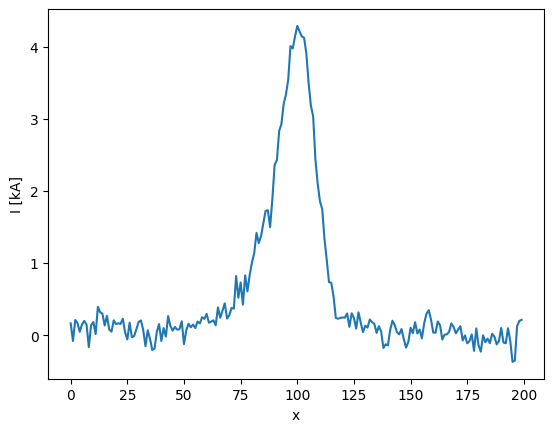

In [37]:
plt.plot(currentProfile_all[1256,:])
plt.xlabel('x')
plt.ylabel('I [kA]')

### WITHOUT PCA

In [178]:
matstruct_to_dict(data_struct)['scalars']['nonBSA_List_S20'].keys()

dict_keys(['XPS_LI20_MC01_M1', 'XPS_LI20_MC01_M2', 'XPS_LI20_MC01_M3', 'XPS_LI20_MC01_M4', 'XPS_LI20_MC01_M5', 'XPS_LI20_MC01_M6', 'XPS_LI20_MC01_M7', 'XPS_LI20_MC01_M8', 'XPS_LI20_MC02_M1', 'XPS_LI20_MC02_M2', 'XPS_LI20_MC02_M3', 'XPS_LI20_MC02_M4', 'XPS_LI20_MC02_M5', 'XPS_LI20_MC02_M6', 'XPS_LI20_MC02_M7', 'XPS_LI20_MC02_M8', 'XPS_LI20_MC03_M1', 'XPS_LI20_MC03_M2', 'XPS_LI20_MC03_M3', 'XPS_LI20_MC03_M4', 'XPS_LI20_MC03_M5', 'XPS_LI20_MC03_M6', 'XPS_LI20_MC03_M7', 'XPS_LI20_MC03_M8', 'XPS_LI20_MC04_M1', 'XPS_LI20_MC04_M2', 'XPS_LI20_MC04_M3', 'XPS_LI20_MC04_M4', 'XPS_LI20_MC04_M5', 'XPS_LI20_MC04_M6', 'XPS_LI20_MC04_M7', 'XPS_LI20_MC04_M8', 'XPS_LI20_MC05_M1', 'XPS_LI20_MC05_M2', 'XPS_LI20_MC05_M3', 'XPS_LI20_MC05_M4', 'XPS_LI20_MC05_M5', 'XPS_LI20_MC05_M6', 'XPS_LI20_MC05_M7', 'XPS_LI20_MC05_M8', 'XPS_LI20_MC10_M1', 'XPS_LI20_MC10_M2', 'XPS_LI20_MC10_M3', 'XPS_LI20_MC10_M4', 'XPS_LI20_MC10_M5', 'MOTR_LI20_MC08_S6_CH1_MOTOR', 'MOTR_LI20_MC08_S6_CH2_MOTOR', 'MOTR_LI20_MC08_S6_CH3_MOTO

In [173]:
set(vars_12710) -set(bsaVars)

{'BLEN_LI20_3014_BRAW',
 'BPMS_LI20_3315_TMIT',
 'BPMS_LI20_3315_X',
 'BPMS_LI20_3315_Y',
 'PMT_LI20_3060_QDCRAW',
 'PMT_LI20_3070_QDCRAW',
 'PMT_LI20_3179_QDCRAW',
 'PMT_LI20_3350_QDCRAW',
 'PMT_LI20_3360_QDCRAW',
 'TCAV_LI20_2400_A',
 'TCAV_LI20_2400_P',
 'WIRE_LI20_3179_POSN'}

Train R²: 97.14 %
Test R²: 95.51 %


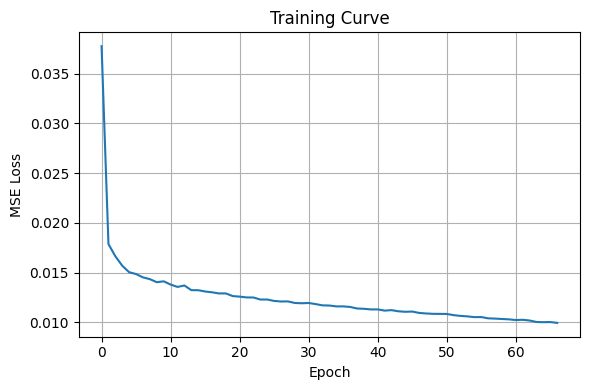

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Compile features and targets
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,goodShots], steps[goodShots])).T
Iz = currentProfile_all[goodShots,:]

# Scale inputs and ouputs
x_scaler = MinMaxScaler()
iz_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor)
Iz_scaled = iz_scaler.fit_transform(Iz)

# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled = train_test_split(
    x_scaled, Iz_scaled, test_size=0.2)

# 20% validation split 
x_train_scaled, X_val, Iz_train_scaled, Y_val = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(Iz_train_scaled, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)

# Define MLP structure
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, out_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1], Y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.5, 0.299))
loss_fn = nn.MSELoss()

# Define custom loss function 
def custom_loss( y_pred,y_true):
    mse = (y_true - y_pred)**2
    dev = abs(torch.maximum(y_true)-torch.maximum(y_pred))
    # weights = (y_true < 2)*2
    return torch.mean(mse) + dev

# Training loop 
n_epochs = 200
patience = 15
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = loss_fn(val_pred, Y_val).item()
        val_losses.append(val_loss)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break
    
model.load_state_dict(best_model_state)
    
# Evaluate model
model.eval()
with torch.no_grad():
    pred_train_scaled = model(X_train).numpy()
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_train_full = iz_scaler.inverse_transform(pred_train_scaled)
pred_test_full = iz_scaler.inverse_transform(pred_test_scaled)
Iz_train_true = iz_scaler.inverse_transform(Iz_train_scaled)
Iz_test_true = iz_scaler.inverse_transform(Iz_test_scaled)

# Compute R²
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

print("Train R²: {:.2f} %".format(r2_score(Iz_train_true.ravel(), pred_train_full.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_true.ravel(), pred_test_full.ravel()) * 100))

# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [190]:
from ipywidgets import interact, IntSlider

# Interactive plot function
def plot_profile(idx):
    plt.plot(Iz_test_true[idx,:], label = "true", alpha = 0.7)
    # plt.plot(double_exponential_smoothing(Iz_test_true[idx,:],0.7, 0.07))
    plt.plot(pred_test_full[idx,:], label = "MLP prediction", alpha = 0.7)
    # plt.plot(pred_test_nopca[idx,:], label = "no-PCA", alpha = 0.7)
    plt.title(f"Predicted Current Profile : Shot {idx}")
    plt.xlabel("x")
    plt.ylabel("I [kA]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create slider
interact(plot_profile, idx=IntSlider(min=0, max=pred_test_full.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=256), Output()), _dom_classes=('widget-interac…

<function __main__.plot_profile(idx)>

In [10]:
import joblib
# joblib.dump(model, 'model/MLP_E338_12710_two_bunch.pkl')
joblib_model = joblib.load('model/MLP_E338_12710_two_bunch.pkl')

In [12]:
# Evaluate 12691 on 12710-trained model 
joblib_model.eval()
with torch.no_grad():
    pred_test_scaled = joblib_model(X_test).numpy()
pred = iz_scaler.inverse_transform(pred_test_scaled).ravel()
true = Iz_test_true.ravel()
r2_score(true, pred)

np.float64(0.9054722395974377)

In [13]:
from ipywidgets import interact, IntSlider

# Interactive plot function
def plot_profile(idx):
    plt.plot(Iz_test_true[idx,:], label = "true", alpha = 0.7)
    # plt.plot(double_exponential_smoothing(Iz_test_true[idx,:],0.7, 0.07))
    plt.plot(iz_scaler.inverse_transform(pred_test_scaled)[idx,:], label = "MLP prediction", alpha = 0.7)
    # plt.plot(pred_test_nopca[idx,:], label = "no-PCA", alpha = 0.7)
    plt.title(f"Predicted Current Profile : Shot {idx}")
    plt.xlabel("x")
    plt.ylabel("I [kA]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create slider
interact(plot_profile, idx=IntSlider(min=0, max=pred_test_full.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=256), Output()), _dom_classes=('widget-interac…

<function __main__.plot_profile(idx)>